In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

data = pd.read_csv("./step_delay_mapping.csv")

model_exec_times = pd.read_parquet("../edgedroid/data/resources/model_exec_times.parquet")
neuro = model_exec_times.groupby(["run_id", "neuroticism"], observed=True).count().reset_index().drop(columns=["ttf", "exec_time"]).set_index("run_id")

data = data.join(other=neuro, on="participant", how="left")
data = data.drop(columns=["start", "end", "duration"], errors="ignore")
data["participant"] = data["participant"].astype("category")
data["delay"] = pd.to_timedelta(data["delay"]).dt.total_seconds()
data["exec_time"] = pd.to_timedelta(data["exec_time"]).dt.total_seconds()
data

,participant,abs_seq,delay,block,block_seq,exec_time,neuroticism
0,134146,0,0.0,0,0,3.029,0.375
1,134146,1,0.0,1,0,4.004,0.375
2,134146,2,0.0,1,1,2.625,0.375
3,134146,3,0.0,1,2,4.680,0.375
4,134146,4,0.0,1,3,5.197,0.375
...,...,...,...,...,...,...,...
6755,137353,164,0.0,21,7,6.358,0.625
6756,137353,165,0.0,21,8,3.840,0.625
6757,137353,166,0.0,21,9,2.932,0.625
6758,137353,167,0.0,21,10,1.874,0.625


In [2]:
import numpy as np

def _block_seq(df: pd.DataFrame) -> pd.DataFrame:
    print(df)
    new_df = pd.DataFrame(index=df.index)
    block_len = len(df.index)
    new_df["block_seq"] = np.arange(block_len)
    new_df["block_len"] = block_len
    return new_df

def _shift(df: pd.DataFrame) -> pd.DataFrame:
    df["block_len"] = df[["block", "participant"]].groupby(["block"]).transform(lambda df: len(df.index))
    df.loc[~np.isin(df["block_len"], [4, 8, 12]), "block_len"] = np.nan
    df[["prev_delay", "prev_block", "prev_block_seq", "prev_block_len"]] = df[["delay", "block", "block_seq", "block_len"]].shift()
    df["prev_ttf"] = df["prev_delay"] * 1.5
    return df

data = data.groupby("participant", as_index=False).apply(_shift).droplevel(0)
data["prev_duration"] = pd.cut(data["prev_block_seq"] + 1, [-np.inf, 5, 9, np.inf], right=False)
data["prev_block_len"] = data["prev_block_len"].astype("category")
data

,participant,abs_seq,delay,block,block_seq,exec_time,neuroticism,block_len,prev_delay,prev_block,prev_block_seq,prev_block_len,prev_ttf,prev_duration
0,134146,0,0.0,0,0,3.029,0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,134146,1,0.0,1,0,4.004,0.375,8.0,0.0,0.0,0.0,NaN,0.0,"[-inf, 5.0)"
2,134146,2,0.0,1,1,2.625,0.375,8.0,0.0,1.0,0.0,8.0,0.0,"[-inf, 5.0)"
3,134146,3,0.0,1,2,4.680,0.375,8.0,0.0,1.0,1.0,8.0,0.0,"[-inf, 5.0)"
4,134146,4,0.0,1,3,5.197,0.375,8.0,0.0,1.0,2.0,8.0,0.0,"[-inf, 5.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,137353,164,0.0,21,7,6.358,0.625,12.0,0.0,21.0,6.0,12.0,0.0,"[5.0, 9.0)"
6756,137353,165,0.0,21,8,3.840,0.625,12.0,0.0,21.0,7.0,12.0,0.0,"[5.0, 9.0)"
6757,137353,166,0.0,21,9,2.932,0.625,12.0,0.0,21.0,8.0,12.0,0.0,"[9.0, inf)"
6758,137353,167,0.0,21,10,1.874,0.625,12.0,0.0,21.0,9.0,12.0,0.0,"[9.0, inf)"


In [3]:
import numpy as np
import numpy.typing as npt
import scipy as sp

# add winsorized columns by block len and step slice
def winsorize(arr: npt.ArrayLike | npt.NDArray, p: int = 5) -> npt.ArrayLike | npt.NDArray:
    low_bound = np.percentile(arr, p)
    high_bound = np.percentile(arr, 100 - p)
    arr[arr < low_bound] = low_bound
    arr[arr > high_bound] = high_bound
    return arr

data["exec_time_winsorized_block_len"] = data.groupby(["prev_ttf", "prev_block_len"])["exec_time"].transform(winsorize)
data["exec_time_winsorized_step_slice"] = data.groupby(["prev_ttf", "prev_duration"])["exec_time"].transform(winsorize)

# add "truncated" columns by block len and step slice
def truncate_to_nan(arr: npt.ArrayLike | npt.NDArray, p: int = 5) -> npt.ArrayLike | npt.NDArray:
    low_bound = np.percentile(arr, p)
    high_bound = np.percentile(arr, 100 - p)
    arr[arr < low_bound] = np.nan
    arr[arr > high_bound] = np.nan
    return arr
    

data["exec_time_truncated_block_len"] = data.groupby(["prev_ttf", "prev_block_len"])["exec_time"].transform(truncate_to_nan)
data["exec_time_truncated_step_slice"] = data.groupby(["prev_ttf", "prev_duration"])["exec_time"].transform(truncate_to_nan)

def iqr_truncate(arr: npt.ArrayLike | npt.NDArray) -> npt.ArrayLike | npt.NDArray:
    iqr = sp.stats.iqr(arr)
    low_bound = np.percentile(arr, 25) - (1.5 * iqr)
    high_bound = np.percentile(arr, 75) + (1.5 * iqr)
    arr[arr < low_bound] = np.nan
    arr[arr > high_bound] = np.nan
    return arr

data["exec_time_iqr_block_len"] = data.groupby(["prev_ttf", "prev_block_len"])["exec_time"].transform(iqr_truncate)
data["exec_time_iqr_step_slice"] = data.groupby(["prev_ttf", "prev_duration"])["exec_time"].transform(iqr_truncate)


data

,participant,abs_seq,delay,block,block_seq,exec_time,neuroticism,block_len,prev_delay,prev_block,prev_block_seq,prev_block_len,prev_ttf,prev_duration,exec_time_winsorized_block_len,exec_time_winsorized_step_slice,exec_time_truncated_block_len,exec_time_truncated_step_slice,exec_time_iqr_block_len,exec_time_iqr_step_slice
0,134146,0,0.0,0,0,3.029,0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,134146,1,0.0,1,0,4.004,0.375,8.0,0.0,0.0,0.0,NaN,0.0,"[-inf, 5.0)",NaN,4.004,NaN,4.004,NaN,4.004
2,134146,2,0.0,1,1,2.625,0.375,8.0,0.0,1.0,0.0,8.0,0.0,"[-inf, 5.0)",2.6250,2.625,2.625,2.625,2.625,2.625
3,134146,3,0.0,1,2,4.680,0.375,8.0,0.0,1.0,1.0,8.0,0.0,"[-inf, 5.0)",4.6800,4.680,4.680,4.680,4.680,4.680
4,134146,4,0.0,1,3,5.197,0.375,8.0,0.0,1.0,2.0,8.0,0.0,"[-inf, 5.0)",5.1970,5.197,5.197,5.197,5.197,5.197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,137353,164,0.0,21,7,6.358,0.625,12.0,0.0,21.0,6.0,12.0,0.0,"[5.0, 9.0)",6.3580,6.358,6.358,6.358,6.358,6.358
6756,137353,165,0.0,21,8,3.840,0.625,12.0,0.0,21.0,7.0,12.0,0.0,"[5.0, 9.0)",3.8400,3.840,3.840,3.840,3.840,3.840
6757,137353,166,0.0,21,9,2.932,0.625,12.0,0.0,21.0,8.0,12.0,0.0,"[9.0, inf)",2.9320,2.932,2.932,2.932,2.932,2.932
6758,137353,167,0.0,21,10,1.874,0.625,12.0,0.0,21.0,9.0,12.0,0.0,"[9.0, inf)",1.9438,1.874,NaN,1.874,1.874,1.874


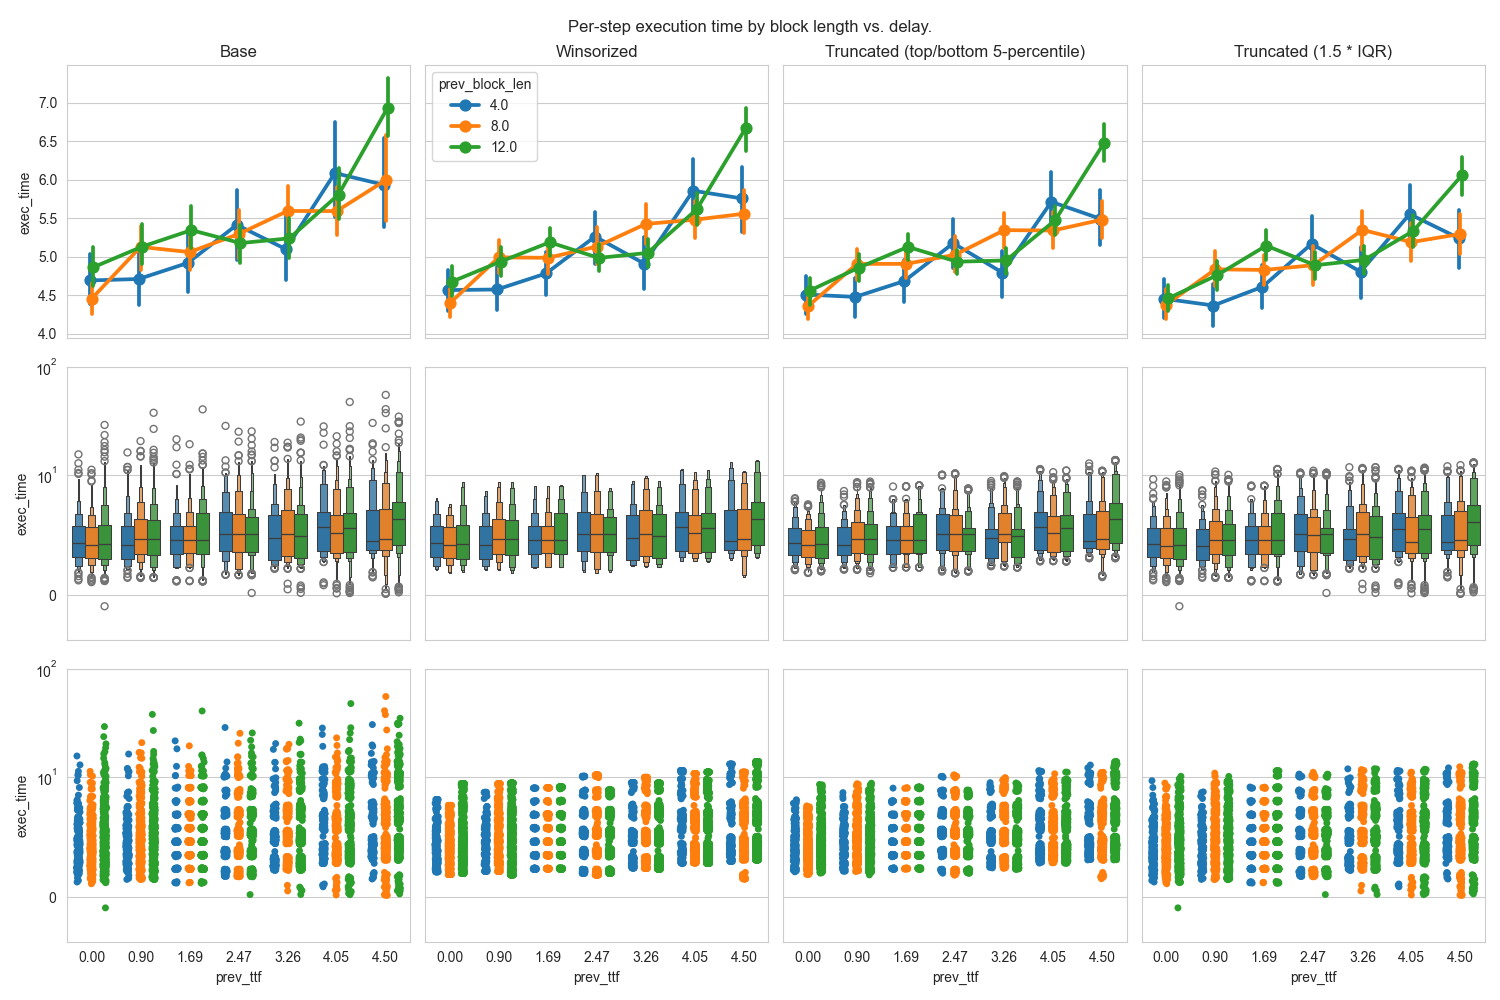

In [5]:
%matplotlib widget

import matplotlib.pyplot as plt
import seaborn as sns


ttfs = np.sort(data["prev_ttf"].dropna().unique())


fig, axes = plt.subplots(nrows=3, ncols=4, sharey="row", sharex=True, figsize=(15, 10))
sns.pointplot(data=data, x="prev_ttf", y="exec_time", hue="prev_block_len", ax=axes[0][0], legend=False, dodge=True)
sns.boxenplot(data=data, x="prev_ttf", y="exec_time", hue="prev_block_len", ax=axes[1][0], legend=False)
sns.stripplot(data=data, x="prev_ttf", y="exec_time", hue="prev_block_len", ax=axes[2][0], legend=False, dodge=True)
axes[0][0].set_title("Base")

sns.pointplot(data=data, x="prev_ttf", y="exec_time_winsorized_block_len", hue="prev_block_len", ax=axes[0][1], dodge=True)
sns.boxenplot(data=data, x="prev_ttf", y="exec_time_winsorized_block_len", hue="prev_block_len", ax=axes[1][1], legend=False)
sns.stripplot(data=data, x="prev_ttf", y="exec_time_winsorized_block_len", hue="prev_block_len", ax=axes[2][1], legend=False, dodge=True)
axes[0][1].set_title("Winsorized")

sns.pointplot(data=data, x="prev_ttf", y="exec_time_truncated_block_len", hue="prev_block_len", ax=axes[0][2], legend=False, dodge=True)
sns.boxenplot(data=data, x="prev_ttf", y="exec_time_truncated_block_len", hue="prev_block_len", ax=axes[1][2], legend=False)
sns.stripplot(data=data, x="prev_ttf", y="exec_time_truncated_block_len", hue="prev_block_len", ax=axes[2][2], legend=False, dodge=True)
axes[0][2].set_title("Truncated (top/bottom 5-percentile)")

sns.pointplot(data=data, x="prev_ttf", y="exec_time_iqr_block_len", hue="prev_block_len", ax=axes[0][3], legend=False, dodge=True)
sns.boxenplot(data=data, x="prev_ttf", y="exec_time_iqr_block_len", hue="prev_block_len", ax=axes[1][3], legend=False)
sns.stripplot(data=data, x="prev_ttf", y="exec_time_iqr_block_len", hue="prev_block_len", ax=axes[2][3], legend=False, dodge=True)
axes[0][3].set_title("Truncated (1.5 * IQR)")

axes[0][0].set_xticks(ticks=axes[0][0].get_xticks(), labels=[f"{t:0.2f}" for t in ttfs])
axes[1][0].set_yscale('symlog', linthresh=10.0)
axes[1][0].set_ylim(None, 100.0)
axes[2][0].set_yscale('symlog', linthresh=10.0)
axes[2][0].set_ylim(None, 100.0)

fig.suptitle("Per-step execution time by block length vs. delay.")
fig.tight_layout()
plt.show()
plt.close(fig)

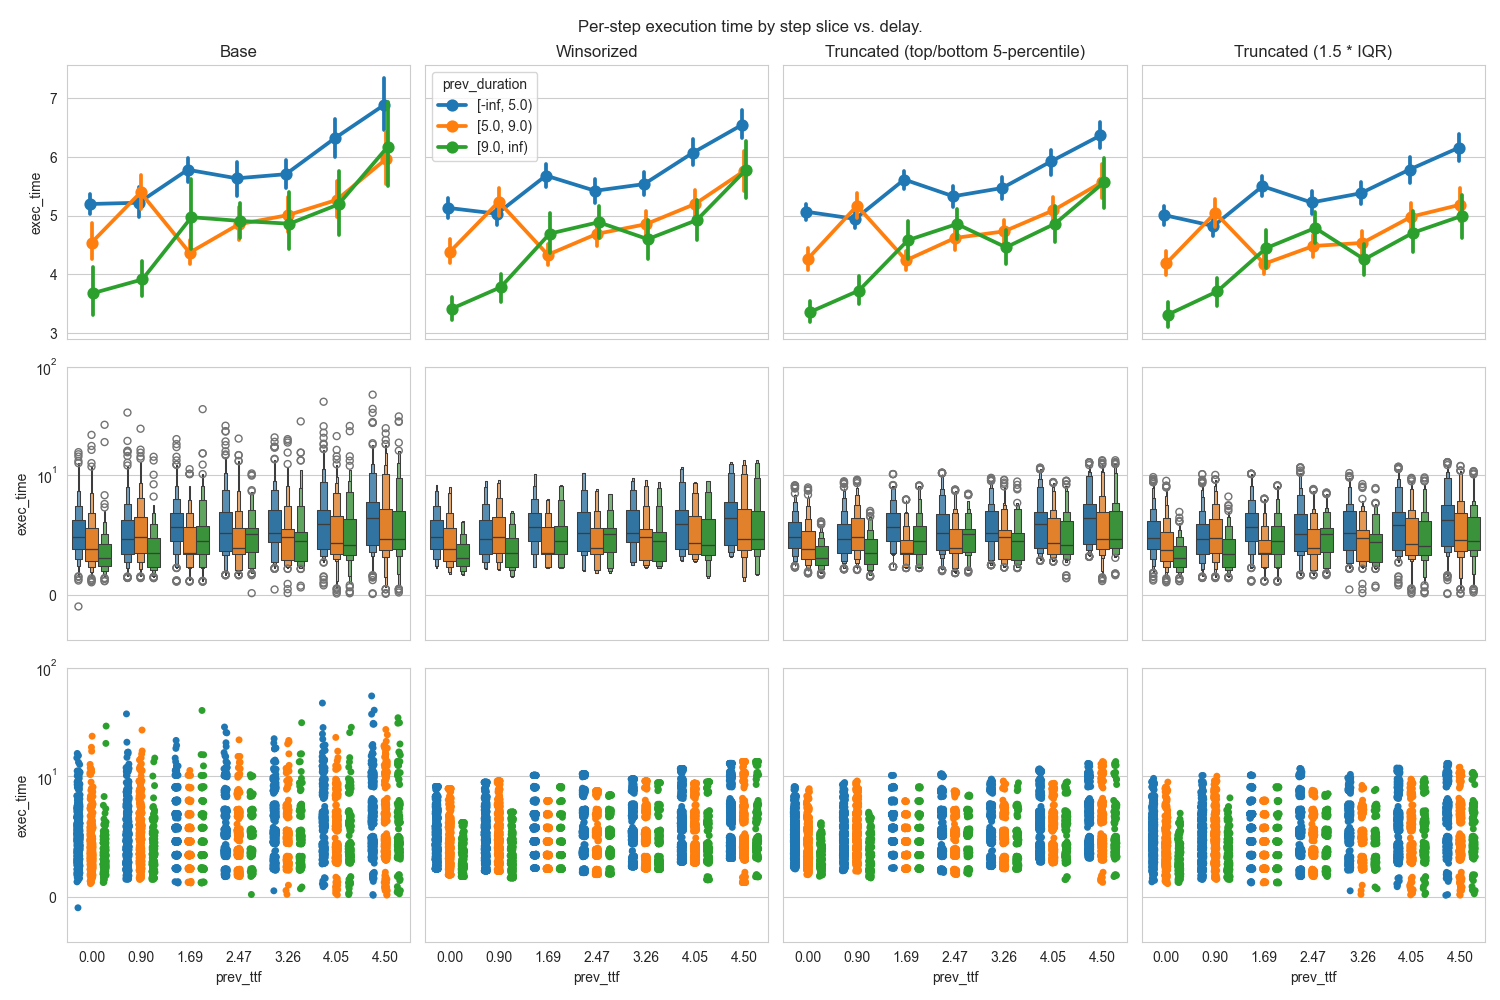

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, sharey="row", sharex=True, figsize=(15, 10))
sns.pointplot(data=data, x="prev_ttf", y="exec_time", hue="prev_duration", ax=axes[0][0], legend=False, dodge=True)
sns.boxenplot(data=data, x="prev_ttf", y="exec_time", hue="prev_duration", ax=axes[1][0], legend=False)
sns.stripplot(data=data, x="prev_ttf", y="exec_time", hue="prev_duration", ax=axes[2][0], legend=False, dodge=True)
axes[0][0].set_title("Base")

sns.pointplot(data=data, x="prev_ttf", y="exec_time_winsorized_step_slice", hue="prev_duration", ax=axes[0][1], dodge=True)
sns.boxenplot(data=data, x="prev_ttf", y="exec_time_winsorized_step_slice", hue="prev_duration", ax=axes[1][1], legend=False)
sns.stripplot(data=data, x="prev_ttf", y="exec_time_winsorized_step_slice", hue="prev_duration", ax=axes[2][1], legend=False, dodge=True)
axes[0][1].set_title("Winsorized")

sns.pointplot(data=data, x="prev_ttf", y="exec_time_truncated_step_slice", hue="prev_duration", ax=axes[0][2], legend=False, dodge=True)
sns.boxenplot(data=data, x="prev_ttf", y="exec_time_truncated_step_slice", hue="prev_duration", ax=axes[1][2], legend=False)
sns.stripplot(data=data, x="prev_ttf", y="exec_time_truncated_step_slice", hue="prev_duration", ax=axes[2][2], legend=False, dodge=True)
axes[0][2].set_title("Truncated (top/bottom 5-percentile)")

sns.pointplot(data=data, x="prev_ttf", y="exec_time_iqr_step_slice", hue="prev_duration", ax=axes[0][3], legend=False, dodge=True)
sns.boxenplot(data=data, x="prev_ttf", y="exec_time_iqr_step_slice", hue="prev_duration", ax=axes[1][3], legend=False)
sns.stripplot(data=data, x="prev_ttf", y="exec_time_iqr_step_slice", hue="prev_duration", ax=axes[2][3], legend=False, dodge=True)
axes[0][3].set_title("Truncated (1.5 * IQR)")

axes[0][0].set_xticks(ticks=axes[0][0].get_xticks(), labels=[f"{t:0.2f}" for t in ttfs])
axes[1][0].set_yscale('symlog', linthresh=10.0)
axes[1][0].set_ylim(None, 100.0)
axes[2][0].set_yscale('symlog', linthresh=10.0)
axes[2][0].set_ylim(None, 100.0)

fig.suptitle("Per-step execution time by step slice vs. delay.")
fig.tight_layout()
plt.show()
plt.close(fig)

# IQR cleanup

In [11]:
from typing import Literal
import functools

def participants_with_extremes(df: pd.DataFrame, column="exec_time", participant_column="participant", p: int = 5, side: Literal["both", "top", "bottom"] = "both") -> set[int]:
    df = df[[participant_column, column]].copy()
    low_bound = np.percentile(df[column], p)
    high_bound = np.percentile(df[column], 100 - p)
    
    if side == "both":
        return set(df.loc[((df[column] > high_bound) | (df[column] < low_bound)), participant_column].unique().tolist())
    elif side == "top":
        return set(df.loc[df[column] > high_bound, participant_column].unique().tolist())
    else:
        return set(df.loc[df[column] < low_bound, participant_column].unique().tolist())


print("Number of participants with at least one outlier (top/bottom 5%) in each combination of prev TTF and prev block length: ", end="")
print(len(
    functools.reduce(
        lambda x, y: x.union(y),
        data
        .groupby(["prev_ttf", "prev_block_len"]).apply(participants_with_extremes),
        set()
    )
))

print("Number of participants with at least one outlier (top/bottom 5%) in each combination of prev TTF and prev slice: ", end="")
print(len(
    functools.reduce(
        lambda x, y: x.union(y),
        data
        .groupby(["prev_ttf", "prev_duration"]).apply(participants_with_extremes),
        set()
    )
))

print("Number of participants with at least one high outlier (top 5%) in each combination of prev TTF and prev block length: ", end="")
print(len(
    functools.reduce(
        lambda x, y: x.union(y),
        data
        .groupby(["prev_ttf", "prev_block_len"]).apply(lambda v: participants_with_extremes(v, p=5, side="top")),
        set()
    )
))

print("Number of participants with at least one high outlier (top 5%) in each combination of prev TTF and prev slice: ", end="")
print(len(
    functools.reduce(
        lambda x, y: x.union(y),
        data
        .groupby(["prev_ttf", "prev_duration"]).apply(lambda v: participants_with_extremes(v, p=5, side="top")),
        set()
    )
))

def participants_with_extremes_iqr(df: pd.DataFrame, column="exec_time", participant_column="participant", side: Literal["both", "top", "bottom"] = "both") -> set[int]:
    df = df[[participant_column, column]].copy()

    iqr = sp.stats.iqr(df[column])
    low_bound = np.percentile(df[column], 25) - (1.5 * iqr)
    high_bound = np.percentile(df[column], 75) + (1.5 * iqr)

    if side == "both":
        return set(df.loc[((df[column] > high_bound) | (df[column] < low_bound)), participant_column].unique().tolist())
    elif side == "top":
        return set(df.loc[df[column] > high_bound, participant_column].unique().tolist())
    else:
        return set(df.loc[df[column] < low_bound, participant_column].unique().tolist())

print("Number of participants with at least one outlier (outside of [p25 - 1.5*iqr, p75 + 1.5*iqr]) in each combination of prev TTF and prev block length: ", end="")
print(len(
    functools.reduce(
        lambda x, y: x.union(y),
        data
        .groupby(["prev_ttf", "prev_block_len"]).apply(participants_with_extremes_iqr),
        set()
    )
))

print("Number of participants with at least one outlier (outside of [p25 - 1.5*iqr, p75 + 1.5*iqr]) in each combination of prev TTF and prev slice: ", end="")
print(len(
    functools.reduce(
        lambda x, y: x.union(y),
        data
        .groupby(["prev_ttf", "prev_duration"]).apply(participants_with_extremes_iqr),
        set()
    )
))

print("Number of participants with at least one high outlier (> p75 + 1.5 * iqr) in each combination of prev TTF and prev block length: ", end="")
print(len(
    functools.reduce(
        lambda x, y: x.union(y),
        data
        .groupby(["prev_ttf", "prev_block_len"]).apply(lambda v: participants_with_extremes_iqr(v, side="top")),
        set()
    )
))

print("Number of participants with at least one high outlier (> p75 + 1.5 * iqr) in each combination of prev TTF and prev slice: ", end="")
print(len(
    functools.reduce(
        lambda x, y: x.union(y),
        data
        .groupby(["prev_ttf", "prev_duration"]).apply(lambda v: participants_with_extremes_iqr(v, side="top")),
        set()
    )
))

Number of participants with at least one outlier (top/bottom 5%) in each combination of prev TTF and prev block length: 40
Number of participants with at least one outlier (top/bottom 5%) in each combination of prev TTF and prev slice: 40
Number of participants with at least one high outlier (top 5%) in each combination of prev TTF and prev block length: 38
Number of participants with at least one high outlier (top 5%) in each combination of prev TTF and prev slice: 40
Number of participants with at least one outlier (outside of [p25 - 1.5*iqr, p75 + 1.5*iqr]) in each combination of prev TTF and prev block length: 37
Number of participants with at least one outlier (outside of [p25 - 1.5*iqr, p75 + 1.5*iqr]) in each combination of prev TTF and prev slice: 37
Number of participants with at least one high outlier (> p75 + 1.5 * iqr) in each combination of prev TTF and prev block length: 37
Number of participants with at least one high outlier (> p75 + 1.5 * iqr) in each combination of pr

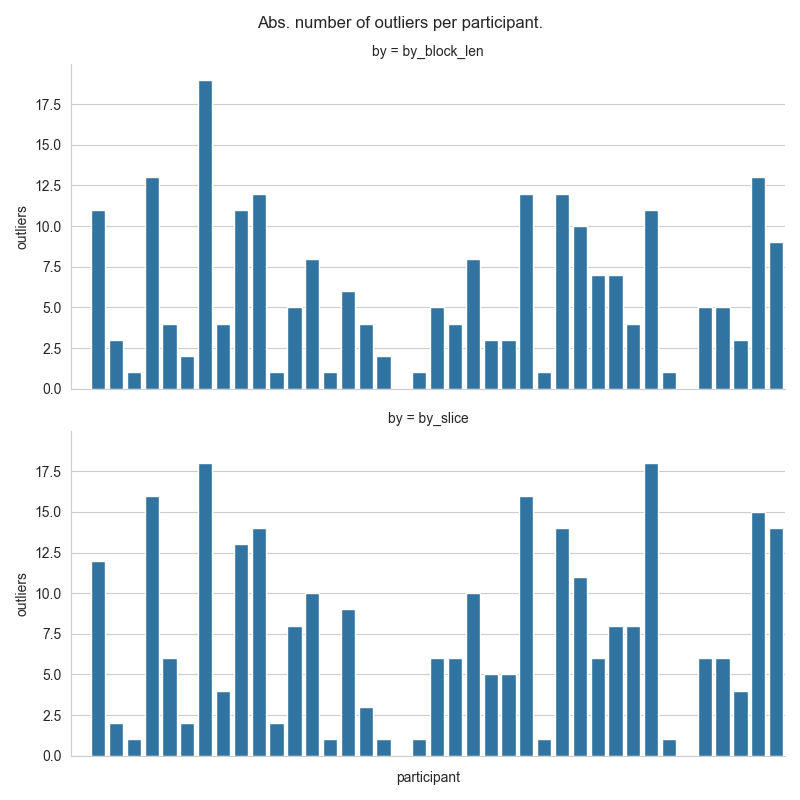

In [53]:
iqr_outliers = pd.DataFrame(columns=["by_block_len", "by_slice"], index=data["participant"].unique())
for p in data["participant"].unique():
    iqr_outliers.loc[p, ["by_block_len", "by_slice"]] = 0

def get_iqr_bounds(v: npt.NDArray | npt.ArrayLike) -> tuple[int | float, int | float]:
    iqr = sp.stats.iqr(v)
    low_bound = np.percentile(v, 25) - (1.5 * iqr)
    high_bound = np.percentile(v, 75) + (1.5 * iqr)
    return low_bound, high_bound

for _, df in data.groupby(["prev_ttf", "prev_block_len"]):
    low_bound, high_bound = get_iqr_bounds(df["exec_time"])
    
    participants = df.loc[((df["exec_time"] > high_bound) | (df["exec_time"] < low_bound)), "participant"]
    for p in participants:
        iqr_outliers.loc[p, "by_block_len"] = iqr_outliers.loc[p, "by_block_len"] + 1

for _, df in data.groupby(["prev_ttf", "prev_duration"]):
    low_bound, high_bound = get_iqr_bounds(df["exec_time"])

    participants = df.loc[((df["exec_time"] > high_bound) | (df["exec_time"] < low_bound)), "participant"]
    for p in participants:
        iqr_outliers.loc[p, "by_slice"] = iqr_outliers.loc[p, "by_slice"] + 1
        
iqr_outliers = iqr_outliers.stack().reset_index().rename(columns={"level_0": "participant", "level_1": "by", 0: "outliers"})

fg = sns.catplot(data=iqr_outliers, kind="bar", x="participant", y="outliers", row="by", height=4, aspect=2)
for ax in fg.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fg.fig.suptitle("Abs. number of outliers per participant.")
fg.fig.tight_layout()
plt.show()

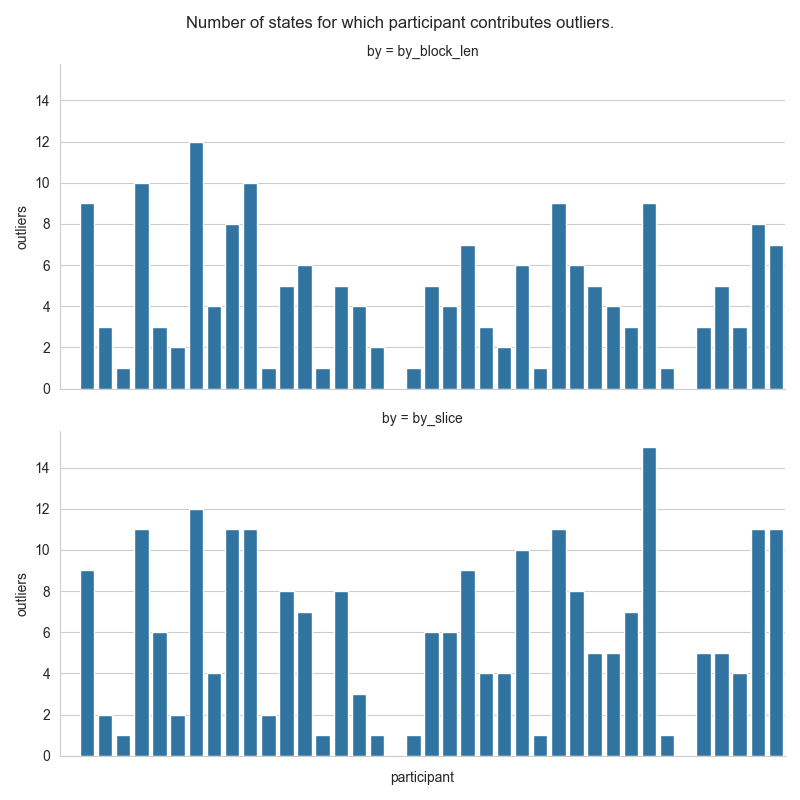

In [54]:
iqr_outliers_unique = pd.DataFrame(columns=["by_block_len", "by_slice"], index=data["participant"].unique())
for p in data["participant"].unique():
    iqr_outliers_unique.loc[p, ["by_block_len", "by_slice"]] = 0

for _, df in data.groupby(["prev_ttf", "prev_block_len"]):
    low_bound, high_bound = get_iqr_bounds(df["exec_time"])

    participants = df.loc[((df["exec_time"] > high_bound) | (df["exec_time"] < low_bound)), "participant"].unique()
    for p in participants:
        iqr_outliers_unique.loc[p, "by_block_len"] = iqr_outliers_unique.loc[p, "by_block_len"] + 1

for _, df in data.groupby(["prev_ttf", "prev_duration"]):
    low_bound, high_bound = get_iqr_bounds(df["exec_time"])

    participants = df.loc[((df["exec_time"] > high_bound) | (df["exec_time"] < low_bound)), "participant"].unique()
    for p in participants:
        iqr_outliers_unique.loc[p, "by_slice"] = iqr_outliers_unique.loc[p, "by_slice"] + 1

iqr_outliers_unique = iqr_outliers_unique.stack().reset_index().rename(columns={"level_0": "participant", "level_1": "by", 0: "outliers"})

fg = sns.catplot(data=iqr_outliers_unique, kind="bar", x="participant", y="outliers", row="by", height=4, aspect=2)
for ax in fg.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fg.fig.suptitle("Number of states for which participant contributes outliers.")
fg.fig.tight_layout()
plt.show()

In [ ]:
# just don't count outliers in verification